In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
from anndata import AnnData

### Read Data

In [2]:
# Replace 'counts_matrix.txt' with the path to your file
counts = pd.read_csv("/scratch/sah2p/projects/G2PDeep-sc-LLM/data/GSE131907/GSE131907_raw_UMI_N_lung.txt", sep="\t", index_col=0)

In [3]:
adata = AnnData(X=counts.T.values)
adata.var_names = counts.index
adata.obs_names = counts.columns

In [4]:
# Split the cell barcodes to extract sample names and barcodes
adata.obs['barcode'] = adata.obs_names.str.split('_').str[0]  # Sample name
adata.obs['Tissue'] = adata.obs_names.str.split('_').str[1]
adata.obs['sample'] = adata.obs_names.str.split('_').str[2]  # Actual barcode

### Split data by Sample

In [ ]:
#Seperate Anndata by Sample
# Create a list of AnnData objects split by sample
adata_by_sample = [adata[adata.obs['sample'] == sample].copy() for sample in adata.obs['sample'].unique()]
adata_by_sample


### Quality Control

Additionally, it is important to note that for datasets with multiple batches, quality control should be performed for each sample individually as quality control thresholds can very substantially between batches.

One can now inspect violin plots of some of the computed QC metrics:

the number of genes expressed in the count matrix

the total counts per cell

the percentage of counts in mitochondrial genes

In [9]:
#Perform QC for each sample
for index, adata_sample in enumerate(adata_by_sample):
    # Calculate mitochondrial gene percentage
    adata_sample.var['mt'] = adata_sample.var_names.str.startswith('MT-')
     # ribosomal genes
    adata_sample.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
    adata_sample.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")# Adjust prefix if necessary
    sc.pp.calculate_qc_metrics(adata_sample, qc_vars=['mt',"ribo", "hb"], inplace=True)
    
    # Filter cells based on QC metrics
    adata_sample = adata_sample[(adata_sample.obs['pct_counts_mt'] <= 20) &
                                (adata_sample.obs['n_genes_by_counts'] > 100) &
                                (adata_sample.obs['n_genes_by_counts'] < 150000) &
                                (adata_sample.obs['total_counts'] > 200) &
                                (adata_sample.obs['total_counts'] < 10000), :]
    
    remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 
          'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']
    
    adata_sample.obs = adata_sample.obs[[x for x in adata_sample.obs.columns if x not in remove]]
    # Store the filtered AnnData object back in the dictionary
    adata_by_sample[index] = adata_sample
    

### Combine Data

In [10]:
# Combine the list of AnnData objects into one
combined_adata = adata_by_sample[0].concatenate(adata_by_sample[1:])

# Check the resulting combined AnnData object
print(combined_adata)


/tmp/ipykernel_2954462/3225622369.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = adata_by_sample[0].concatenate(adata_by_sample[1:])


AnnData object with n_obs × n_vars = 33305 × 29634
    obs: 'barcode', 'Tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells_by_counts-10', 'mean_counts-10', 'log1p_mean_counts-10', 'pct_dropout_by_counts-10', 'total_counts-10', 'log1p_total_counts-10', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_total_counts-2', 'n_cells_by_counts-3', 'mean_counts-3', 'log1p_mean_counts-3', 'pct_dropout_

### Doublet Detection

In [11]:
sc.pp.scrublet(combined_adata, batch_key="sample")

### Normalization

In [12]:
#Saving Counts Data
combined_adata.layers['counts'] = combined_adata.X.copy()

In [13]:
# Normalizing to median total counts
sc.pp.normalize_total(combined_adata)
# Logarithmize the data:
sc.pp.log1p(combined_adata)

### Feature Selection

In [14]:
sc.pp.highly_variable_genes(combined_adata, n_top_genes=2000, batch_key="sample")


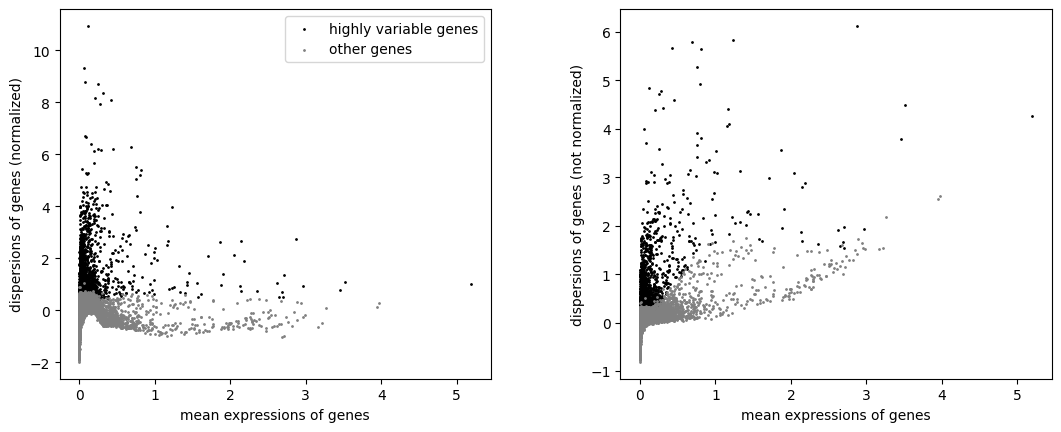

In [15]:
sc.pl.highly_variable_genes(combined_adata)


### Dimensionality Reduction

In [16]:
sc.tl.pca(combined_adata)


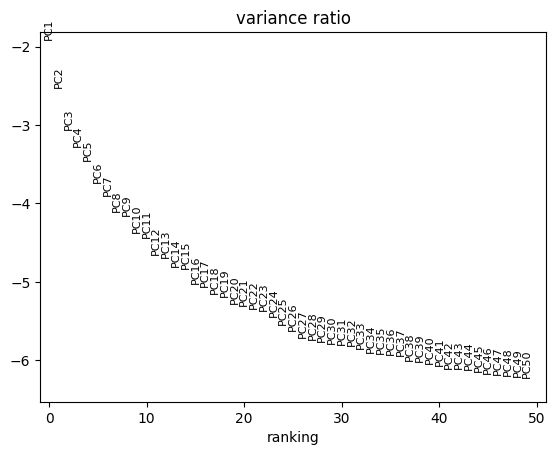

In [17]:
sc.pl.pca_variance_ratio(combined_adata, n_pcs=50, log=True)


### Visulization

In [18]:
sc.pp.neighbors(combined_adata)


In [19]:
sc.tl.umap(combined_adata)


In [20]:
sc.tl.tsne(combined_adata)

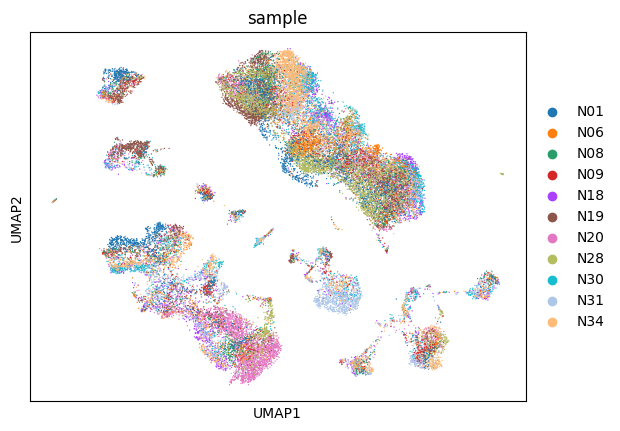

In [21]:
sc.pl.umap(combined_adata, color='sample')

### Clustering

In [25]:
sc.tl.leiden(combined_adata,  key_added='leiden_res0.01',resolution=0.01)
sc.tl.leiden(combined_adata, key_added='leiden_res0.02',resolution=0.02)
sc.tl.leiden(combined_adata, key_added='leiden_res0.05',resolution=0.05)
sc.tl.leiden(combined_adata,  key_added='leiden_res0.1',resolution=0.1)
sc.tl.leiden(combined_adata, key_added='leiden_res0.5',resolution=0.5)





/tmp/ipykernel_2954462/2884637946.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(combined_adata,  key_added='leiden_res0.01',resolution=0.01)


In [23]:
sc.tl.louvain(combined_adata,  key_added='louvain_res0.01',resolution=0.01)
sc.tl.louvain(combined_adata,  key_added='louvain_res0.02',resolution=0.02)
sc.tl.louvain(combined_adata,  key_added='louvain_res0.05',resolution=0.05)
sc.tl.louvain(combined_adata,  key_added='louvain_res0.1',resolution=0.1)
sc.tl.louvain(combined_adata,  key_added='louvain_res0.5',resolution=0.5)

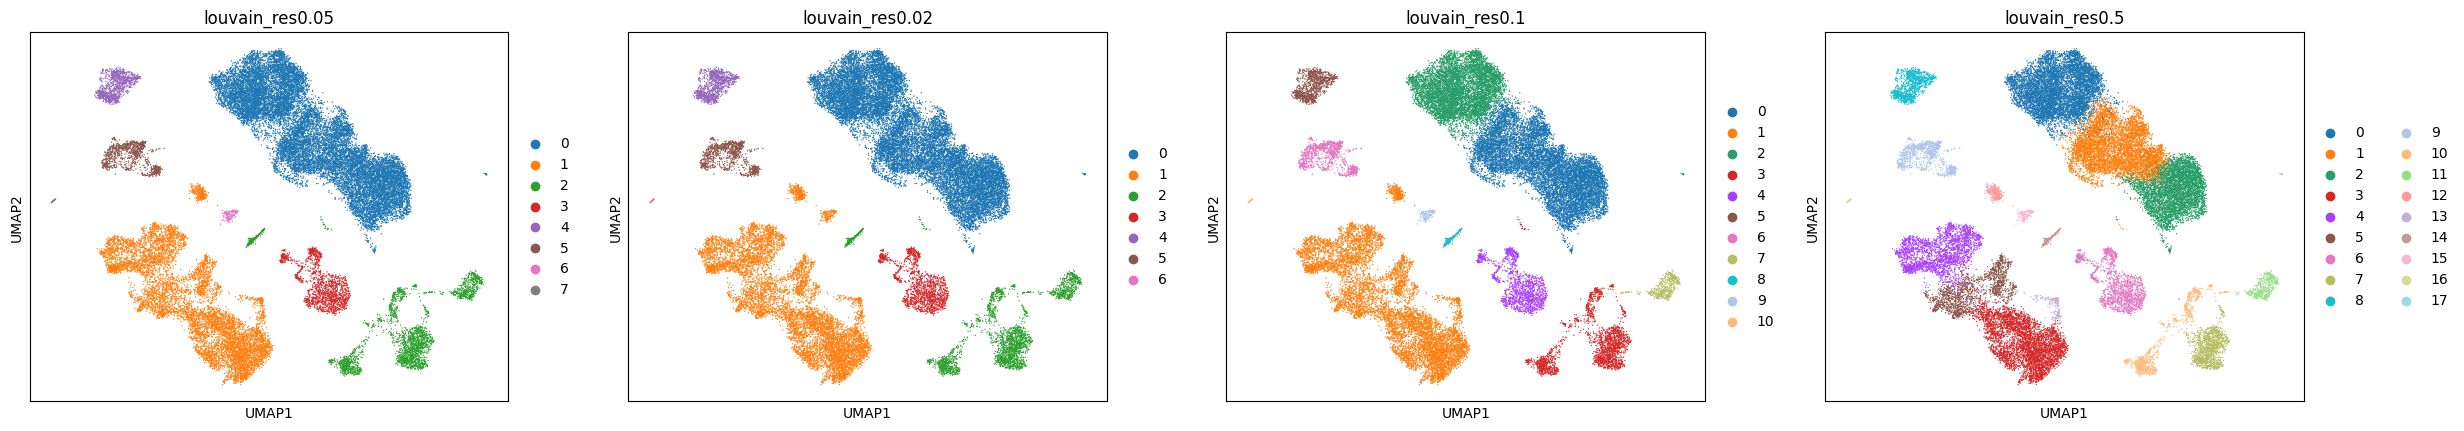

In [26]:
sc.pl.umap(combined_adata, color=['louvain_res0.05','louvain_res0.02','louvain_res0.1','louvain_res0.5'])

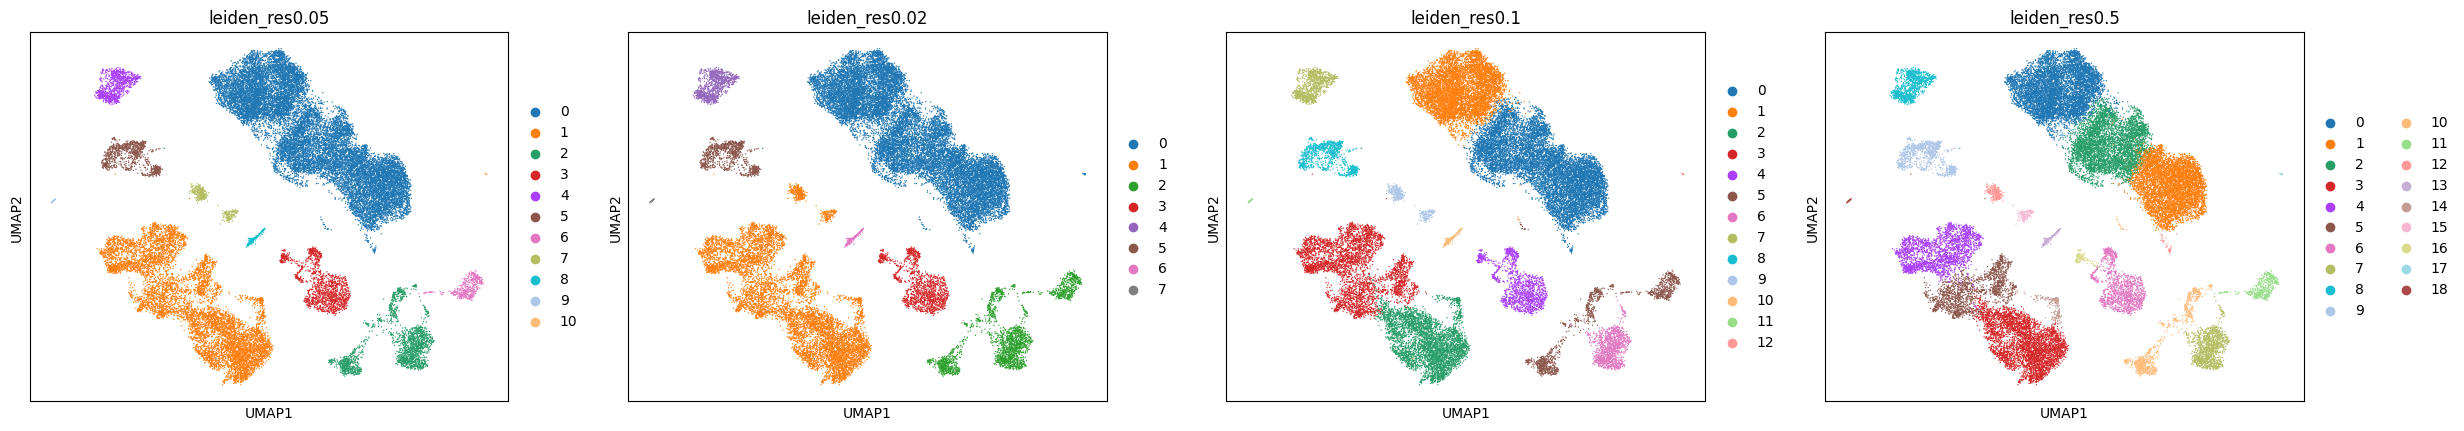

In [27]:
sc.pl.umap(combined_adata, color=['leiden_res0.05','leiden_res0.02','leiden_res0.1','leiden_res0.5'])

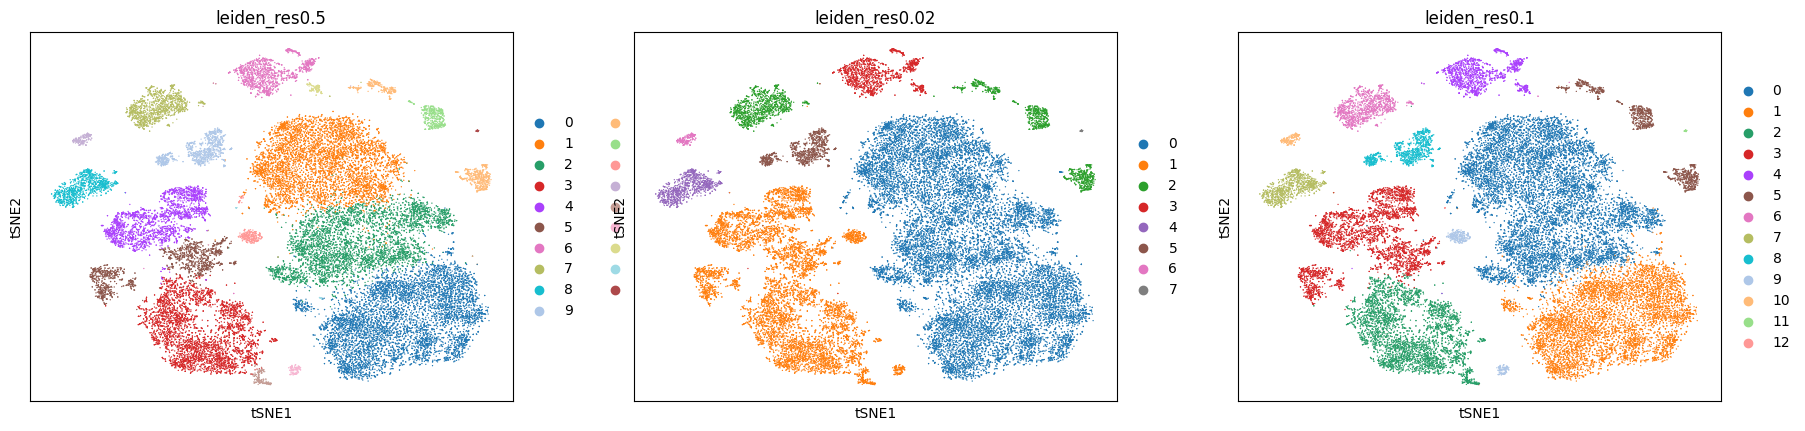

In [28]:
sc.pl.tsne(combined_adata,color=['leiden_res0.5','leiden_res0.02','leiden_res0.1'])

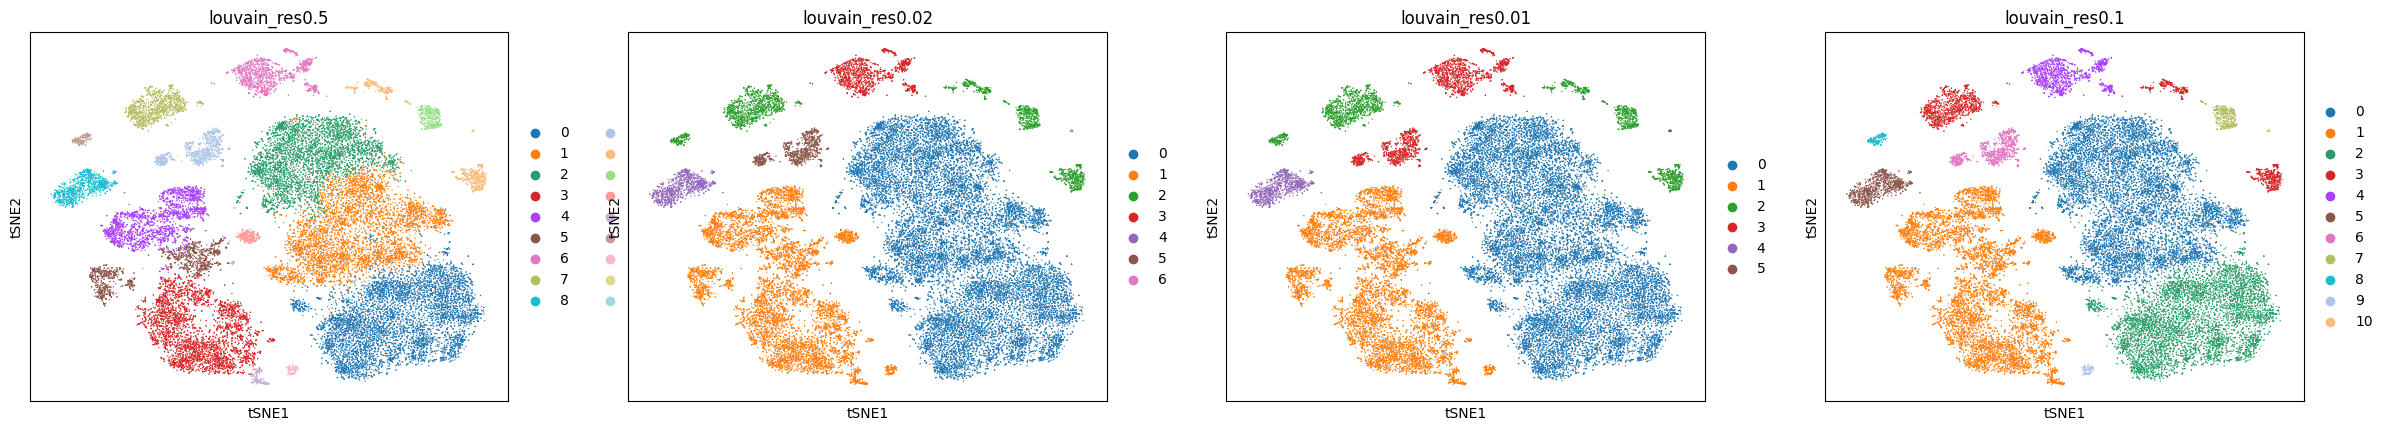

In [30]:
sc.pl.tsne(combined_adata,color=['louvain_res0.5','louvain_res0.02','louvain_res0.01','louvain_res0.1'])

### Re-assess quality control and cell filtering

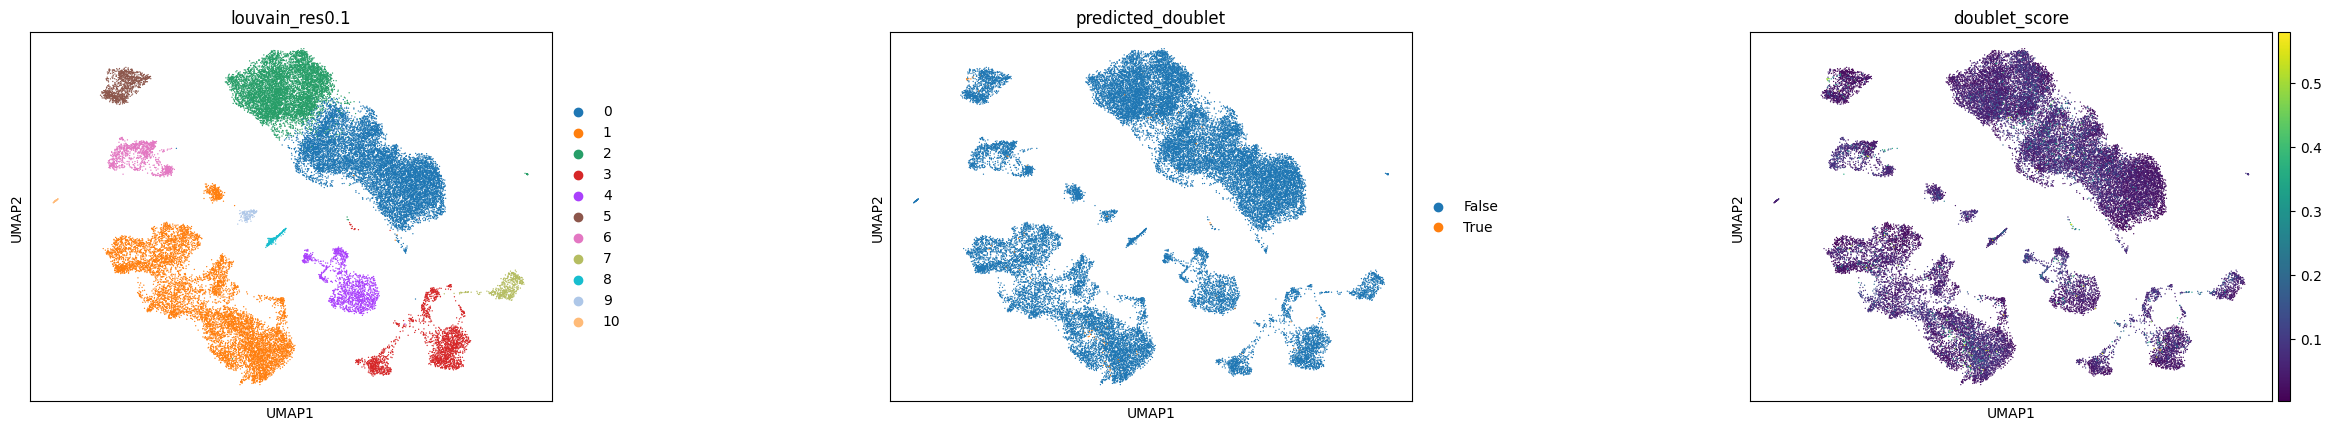

In [31]:
combined_adata.obs["predicted_doublet"] = combined_adata.obs["predicted_doublet"].astype("category")
sc.pl.umap(
    combined_adata,
    color=["louvain_res0.1", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
)

#### Subset the Ann data to exclude cells predicted as doublets

In [32]:
combined_adata = combined_adata[~combined_adata.obs['predicted_doublet'].to_numpy()].copy()

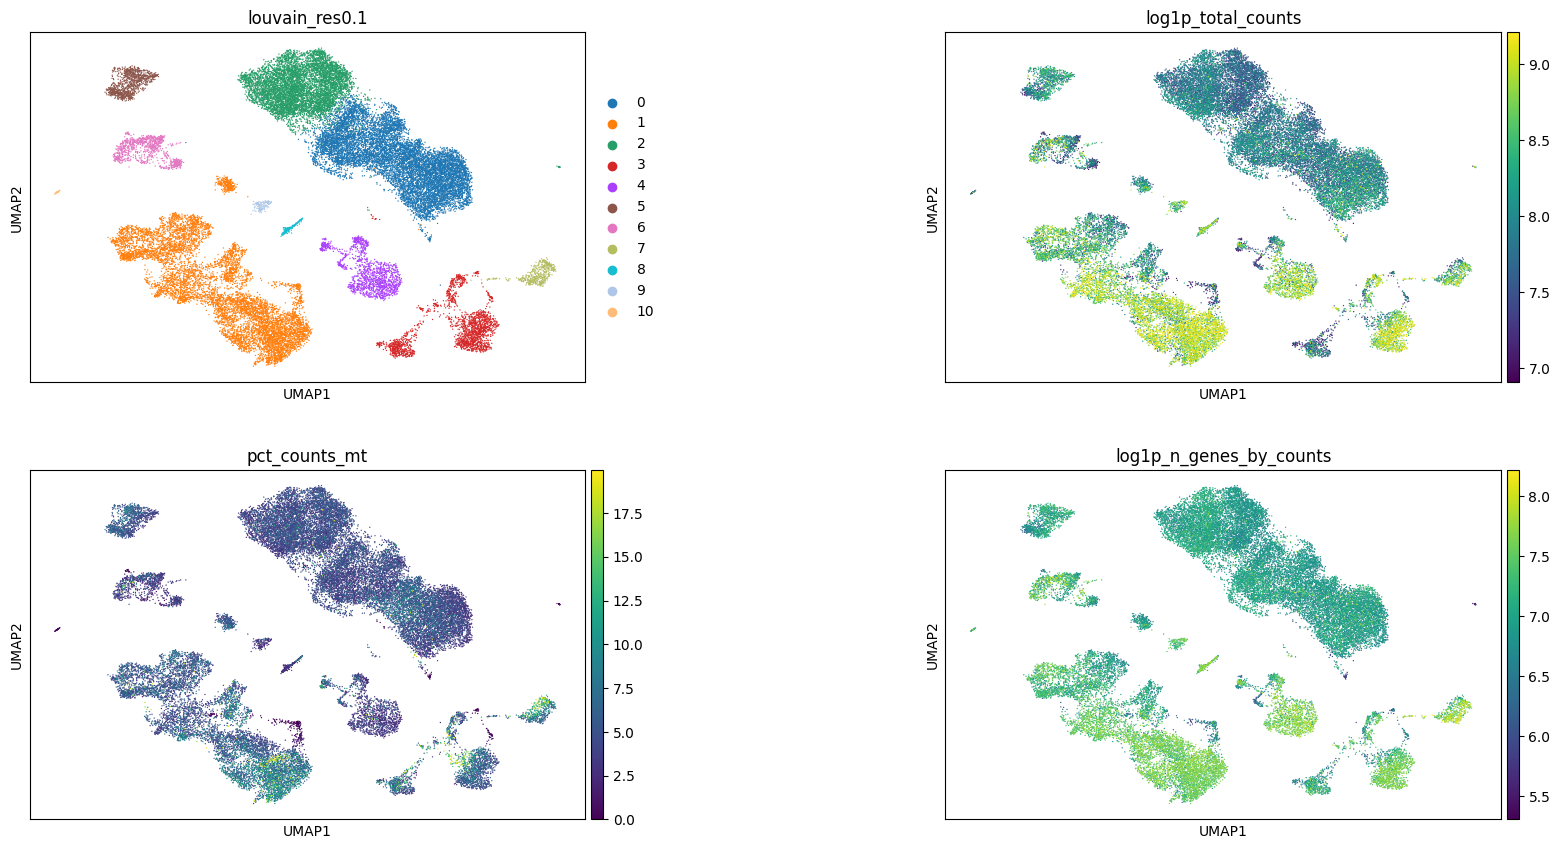

In [33]:
sc.pl.umap(
    combined_adata, color=["louvain_res0.1", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"], wspace=0.5, ncols=2
)

### Cell-type annotation

In [ ]:
# !pip install celltypist
# !pip install decoupler
# !pip install omnipath

In [34]:
# import celltypist as ct
# from celltypist import models
import decoupler as dc


In [36]:
# demo set
# marker_genes = {
#     "CD14+ Mono": ["FCN1", "CD14"],
#     "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
#     # Note: DMXL2 should be negative
#     "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
#     "Erythroblast": ["MKI67", "HBA1", "HBB"],
#     # Note HBM and GYPA are negative markers
#     "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
#     "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
#     "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
#     "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
#     # Note IGHD and IGHM are negative markers
#     "B cells": ["MS4A1", "ITGB1", "COL4A4", "PRDM1", "IRF4", "PAX5", "BCL11A", "BLK", "IGHD", "IGHM"],
#     "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
#     "Plasmablast": ["XBP1", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
#     "CD4+ T": ["CD4", "IL7R", "TRBC2"],
#     "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
#     "T naive": ["LEF1", "CCR7", "TCF7"],
#     "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
# }
paper_marker_genes = {
   
    "Epithelial cells": ["EPCAM", "KRT19", "KRT18", "CDH1"],
    "Fibroblasts": ["DCN", "THY1", "COL1A1", "COL1A2"],
    "Endothelial cells": ["PECAM1", "CLDN5", "FLT1", "RAMP2"],
    "T lymphocytes": ["CD3D", "CD3E", "CD3G", "TRAC"],
    "NK cells": ["NKG7", "GNLY", "NCAM1", "KLRD1"],
    "B lymphocytes": ["CD79A", "IGHM", "IGHG3", "IGHA2"],
    "Myeloid cells": ["LYZ", "MARCO", "CD68", "FCGR3A"],
    "MAST cells": ["KIT", "MS4A2", "GATA2"],
    "Other (possibly Oligodendrocytes)": ["OLIG1", "OLIG2", "MOG", "CLDN11"]
}


In [37]:
def group_max(adata: sc.AnnData, groupby: str) -> str:
    import pandas as pd

    agg = sc.get.aggregate(adata, by=groupby, func="mean")
    return pd.Series(agg.layers["mean"].sum(1), agg.obs[groupby]).idxmax()

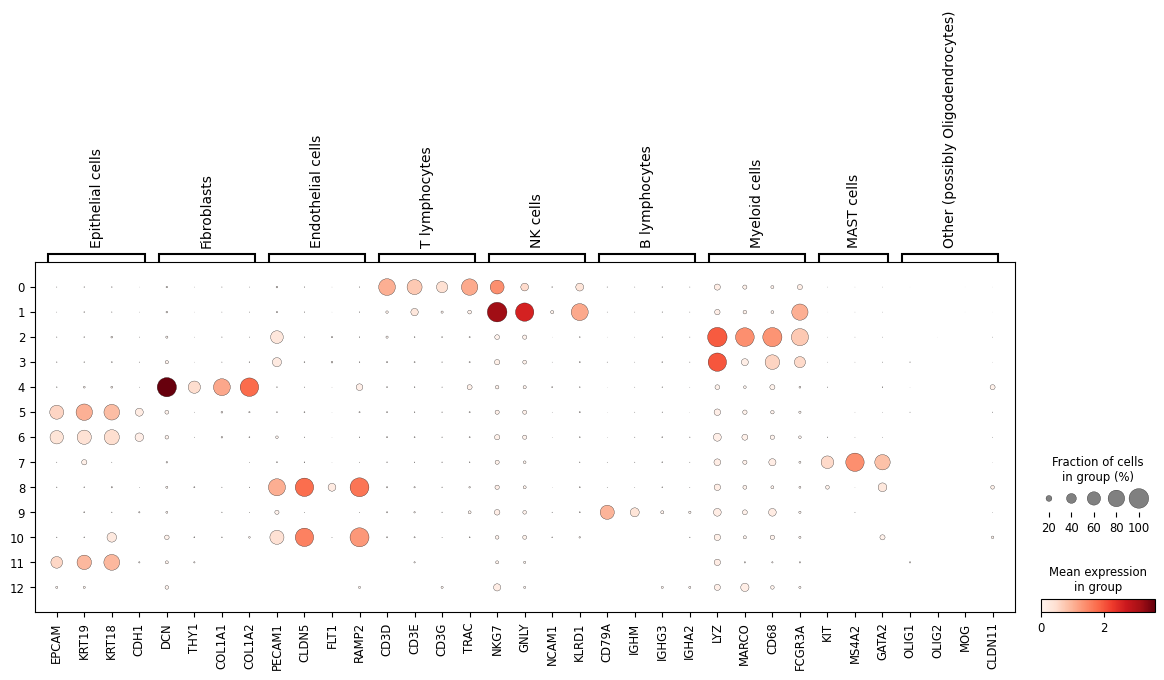

In [61]:
sc.pl.dotplot(combined_adata, paper_marker_genes, groupby="leiden_res0.1")


In [93]:
#  Manually annotate clusters based on marker gene expression
cluster_annotation = {
    '0': 'T lymphocytes',
    '1': 'NK cells',
    '2': 'Myeloid cells',
    '3': 'Myeloid cells',
    '4': 'Fibroblasts',
    '5': 'Epithelial cells',
    '6': 'Epithelial cells',
    '7': 'Mast cells',
    '8': 'Endothelial cells',
    '9': 'B lymphocytes',
    '10': 'Endothelial cells',
    '11': 'Epithelial cells',
    '12': 'Others',
}
combined_adata.obs['mcell_type'] = combined_adata.obs['leiden_res0.1'].map(cluster_annotation)

### Automatic label Prediction

In [94]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource(name="PanglaoDB", organism="human")
# Keep canonical cell type markers alone
markers = markers[markers["canonical_marker"]]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]
markers.head()

genesymbol  canonical_marker                     cell_type germ_layer  \
1      CTRB1              True                  Acinar cells   Endoderm   
2       KLK1              True             Endothelial cells   Mesoderm   
5       KLK1              True               Principal cells   Mesoderm   
6       KLK1              True                  Acinar cells   Endoderm   
7       KLK1              True  Plasmacytoid dendritic cells   Mesoderm   

   human  human_sensitivity  human_specificity  mouse  mouse_sensitivity  \
1   True           1.000000           0.000629   True           0.957143   
2   True           0.000000           0.008420   True           0.000000   
5   True           0.000000           0.008145   True           0.285714   
6   True           0.833333           0.005031   True           0.314286   
7   True           0.000000           0.008202   True           1.000000   

   mouse_specificity  ncbi_tax_id          organ  ubiquitiousness  
1           0.015920         9606       Pancreas            0.017  
2           0.014915         9606    Vasculature            0.013  
5           0.014058         9606         Kidney            0.013  
6           0.012826         9606       Pancreas            0.013  
7           0.012914         9606  Immune system            0.013

In [81]:
markers[markers['cell_type'].str.contains('Mye')]

genesymbol  canonical_marker                         cell_type  \
877      S100A4              True  Myeloid-derived suppressor cells   
2718     S100A9              True  Myeloid-derived suppressor cells   

     germ_layer  human  human_sensitivity  human_specificity  mouse  \
877    mesoderm   True                0.0           0.371241   True   
2718   mesoderm   True                0.0           0.103383   True   

      mouse_sensitivity  mouse_specificity  ncbi_tax_id          organ  \
877                 0.0                0.0         9606  Immune system   
2718                0.0                0.0         9606  Immune system   

      ubiquitiousness  
877             0.098  
2718            0.061

In [95]:
dc.run_mlm(mat=combined_adata, net=markers, weight=None, source="cell_type", target="genesymbol", verbose=True, use_raw=False)


4549 features of mat are empty, they will be removed.
Running mlm on mat with 33184 samples and 25085 targets for 136 sources.


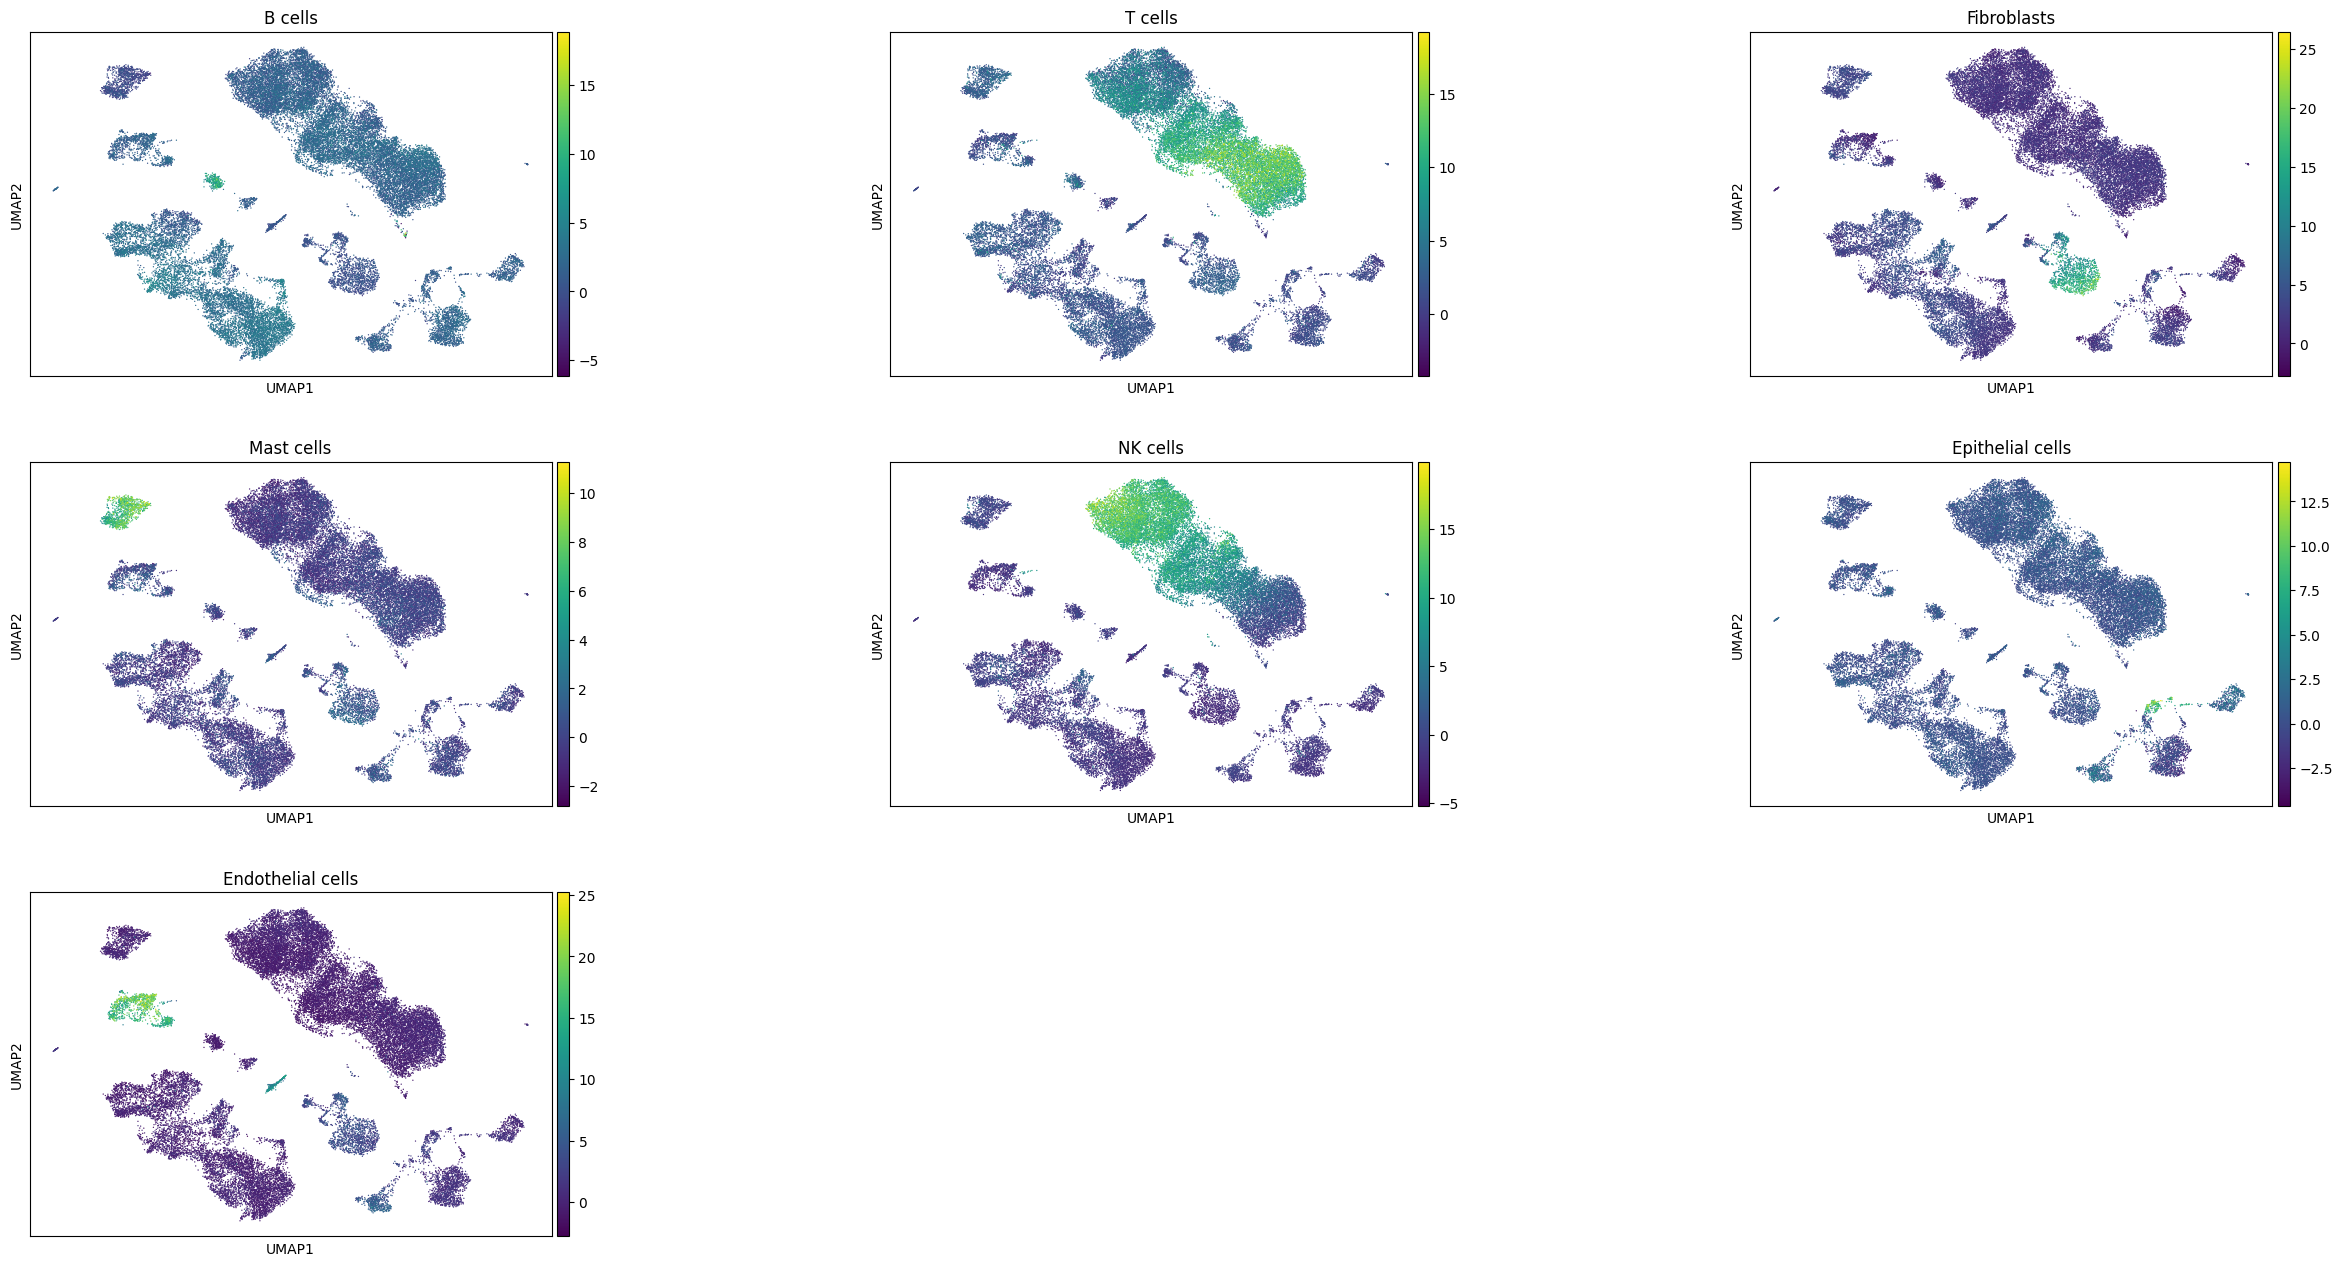

In [96]:
acts = dc.get_acts(adata=combined_adata, obsm_key="mlm_estimate")
sc.pl.umap(
    acts,
    color=[
        # "majority_voting",
        "B cells",
        "T cells",
        "Fibroblasts",
        "Mast cells",
        "NK cells",
        "Epithelial cells",
        "Endothelial cells"
    ],
    wspace=0.5,
    ncols=3,
)

In [97]:
mean_enr = dc.summarize_acts(acts, groupby="leiden_res0.1", min_std=1.0)
annotation_dict = dc.assign_groups(mean_enr)
combined_adata.obs["dc_anno"] = [annotation_dict[clust] for clust in combined_adata.obs["leiden_res0.1"]]

In [98]:
combined_adata.obs

barcode Tissue sample  \
AAACCTGAGAAGGTGA_LUNG_N18-0   AAACCTGAGAAGGTGA   LUNG    N18   
AAACCTGAGACAAAGG_LUNG_N18-0   AAACCTGAGACAAAGG   LUNG    N18   
AAACCTGAGTGCGTGA_LUNG_N18-0   AAACCTGAGTGCGTGA   LUNG    N18   
AAACCTGAGTGTGAAT_LUNG_N18-0   AAACCTGAGTGTGAAT   LUNG    N18   
AAACCTGAGTTGCAGG_LUNG_N18-0   AAACCTGAGTTGCAGG   LUNG    N18   
...                                        ...    ...    ...   
TTTGTCAAGTGATCGG_LUNG_N28-10  TTTGTCAAGTGATCGG   LUNG    N28   
TTTGTCAGTAAATGTG_LUNG_N28-10  TTTGTCAGTAAATGTG   LUNG    N28   
TTTGTCAGTACCGCTG_LUNG_N28-10  TTTGTCAGTACCGCTG   LUNG    N28   
TTTGTCAGTGATGTCT_LUNG_N28-10  TTTGTCAGTGATGTCT   LUNG    N28   
TTTGTCATCTCCGGTT_LUNG_N28-10  TTTGTCATCTCCGGTT   LUNG    N28   

                              n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCTGAGAAGGTGA_LUNG_N18-0                1113                 7.015712   
AAACCTGAGACAAAGG_LUNG_N18-0                1100                 7.003974   
AAACCTGAGTGCGTGA_LUNG_N18-0                1163                 7.059618   
AAACCTGAGTGTGAAT_LUNG_N18-0                 977                 6.885510   
AAACCTGAGTTGCAGG_LUNG_N18-0                 820                 6.710523   
...                                         ...                      ...   
TTTGTCAAGTGATCGG_LUNG_N28-10               1121                 7.022868   
TTTGTCAGTAAATGTG_LUNG_N28-10               1722                 7.451822   
TTTGTCAGTACCGCTG_LUNG_N28-10               1143                 7.042286   
TTTGTCAGTGATGTCT_LUNG_N28-10               1685                 7.430114   
TTTGTCATCTCCGGTT_LUNG_N28-10                907                 6.811244   

                              total_counts  log1p_total_counts  \
AAACCTGAGAAGGTGA_LUNG_N18-0           3214            8.075583   
AAACCTGAGACAAAGG_LUNG_N18-0           2990            8.003363   
AAACCTGAGTGCGTGA_LUNG_N18-0           2653            7.883823   
AAACCTGAGTGTGAAT_LUNG_N18-0           3021            8.013674   
AAACCTGAGTTGCAGG_LUNG_N18-0           1922            7.561642   
...                                    ...                 ...   
TTTGTCAAGTGATCGG_LUNG_N28-10          2473            7.813592   
TTTGTCAGTAAATGTG_LUNG_N28-10          5788            8.663715   
TTTGTCAGTACCGCTG_LUNG_N28-10          3344            8.115222   
TTTGTCAGTGATGTCT_LUNG_N28-10          5743            8.655911   
TTTGTCATCTCCGGTT_LUNG_N28-10          2221            7.706163   

                              pct_counts_in_top_50_genes  \
AAACCTGAGAAGGTGA_LUNG_N18-0                    37.678905   
AAACCTGAGACAAAGG_LUNG_N18-0                    36.254181   
AAACCTGAGTGCGTGA_LUNG_N18-0                    31.926121   
AAACCTGAGTGTGAAT_LUNG_N18-0                    44.455478   
AAACCTGAGTTGCAGG_LUNG_N18-0                    38.813736   
...                                                  ...   
TTTGTCAAGTGATCGG_LUNG_N28-10                   36.554792   
TTTGTCAGTAAATGTG_LUNG_N28-10                   42.259848   
TTTGTCAGTACCGCTG_LUNG_N28-10                   40.968900   
TTTGTCAGTGATGTCT_LUNG_N28-10                   44.454118   
TTTGTCATCTCCGGTT_LUNG_N28-10                   42.098154   

                              pct_counts_in_top_100_genes  \
AAACCTGAGAAGGTGA_LUNG_N18-0                     53.453640   
AAACCTGAGACAAAGG_LUNG_N18-0                     51.471572   
AAACCTGAGTGCGTGA_LUNG_N18-0                     45.081040   
AAACCTGAGTGTGAAT_LUNG_N18-0                     60.575968   
AAACCTGAGTTGCAGG_LUNG_N18-0                     52.445369   
...                                                   ...   
TTTGTCAAGTGATCGG_LUNG_N28-10                    47.634452   
TTTGTCAGTAAATGTG_LUNG_N28-10                    52.505183   
TTTGTCAGTACCGCTG_LUNG_N28-10                    55.502392   
TTTGTCAGTGATGTCT_LUNG_N28-10                    55.650357   
TTTGTCATCTCCGGTT_LUNG_N28-10                    54.840162   

                              pct_counts_in_top_200_genes  ...  \
AAACCTGAGAAGGTGA_LUNG_N18-0                 

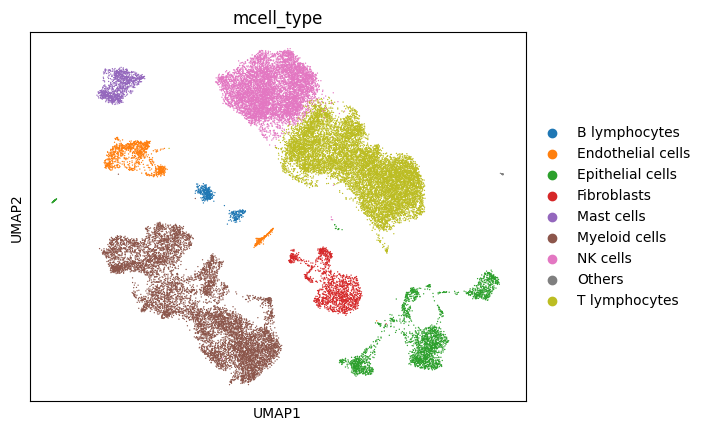

In [99]:
sc.pl.umap(combined_adata, color=["mcell_type"], ncols=1)


In [100]:
df_cell_annotation = pd.read_csv("/scratch/sah2p/projects/G2PDeep-sc-LLM/data/GSE131907/GSE131907_Lung_Cancer_cell_annotation.txt",sep='\t')

In [131]:
df_nlung = df_cell_annotation[df_cell_annotation['Sample_Origin'] == 'nLung']
df_nlung = df_nlung[['Barcode','Cell_type']].drop_duplicates(subset='Barcode')

In [139]:
dict_lungn = df_nlung.set_index('Barcode')['Cell_type'].to_dict()
combined_adata.obs['lcell_type'] = combined_adata.obs['barcode'].map(dict_lungn)

AAACCTGCAAGGTGTG Myeloid cells
AACTCCCGTTCACCTC Myeloid cells
AACTCCCTCACGCGGT Myeloid cells
AAGGAGCGTGTGCGTC Myeloid cells
AAGGTTCAGGTACTCT Myeloid cells
ACACCAAAGTGTACGG Myeloid cells
ACACTGAAGTACTTGC Myeloid cells
ACGCCGACACGCGAAA Myeloid cells
ACGGAGAGTTGAGGTG Myeloid cells
ACTGAACTCCTCAATT Myeloid cells
ACTGAGTTCTGATACG Myeloid cells
AGAGTGGGTATAATGG Myeloid cells
AGCAGCCCATCCTTGC Myeloid cells
AGCGGTCAGTACGCGA Myeloid cells
AGCTCCTGTCCAAGTT Myeloid cells
AGTCTTTGTAGCGATG Myeloid cells
ATAACGCTCGGACAAG Myeloid cells
CACACTCCACTGAAGG Myeloid cells
CACATAGTCATGCATG Myeloid cells
CACCAGGTCCAGAAGG Myeloid cells
CACTCCATCTAAGCCA Myeloid cells
CAGATCATCCATTCTA Myeloid cells
CAGTCCTGTAGCCTCG Myeloid cells
CATATGGCATCTATGG Myeloid cells
CATATGGTCTTTAGTC Myeloid cells
CATGGCGGTTGGGACA Myeloid cells
CATTCGCCATCGGACC Myeloid cells
CCACTACCACTGAAGG Myeloid cells
CCTCAGTAGGCAGTCA Myeloid cells
CCTTACGGTATTACCG Myeloid cells
CGACTTCGTTCGTGAT Myeloid cells
CGCGTTTAGCTGAAAT Myeloid cells
CGCTTCAT

In [141]:
combined_adata.write('/scratch/sah2p/projects/G2PDeep-sc-LLM/data/GSE131907/combined_adata.h5ad')